#📌 Extracción

In [8]:
# 📌 Paso 1: Importar librerías necesarias
import pandas as pd
import requests

# 📌 Paso 2: Definir la URL del archivo JSON en formato raw
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# 📌 Paso 3: Realizar la solicitud GET para obtener los datos
response = requests.get(url)

# 📌 Paso 4: Convertir el contenido JSON en un DataFrame de pandas
data_json = response.json()
df = pd.DataFrame(data_json)

# 📌 Paso 5: Mostrar las primeras filas para verificar la carga
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformación

In [2]:
# Ver columnas y tipos de datos
df.info()

# Alternativamente
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


,0
customerID,object
Churn,object
customer,object
phone,object
internet,object
account,object


In [9]:
# Verificar tipos de datos detalladamente
df.applymap(type).nunique()

/tmp/ipython-input-3702349118.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(type).nunique()


,0
customerID,1
Churn,1
customer,1
phone,1
internet,1
account,1


In [10]:
# Verificar el tipo de cada celda en cada columna
for col in df.columns:
    tipos = df[col].apply(type).unique()
    print(f"{col}: {tipos}")

customerID: [<class 'str'>]
Churn: [<class 'str'>]
customer: [<class 'dict'>]
phone: [<class 'dict'>]
internet: [<class 'dict'>]
account: [<class 'dict'>]


In [12]:
# Normalizar columnas anidadas
from pandas import json_normalize

# Normalizar cada columna que contenga diccionarios
for col in ['customer', 'phone', 'internet', 'account']:
    if df[col].apply(lambda x: isinstance(x, dict)).all():
        normalized = json_normalize(df[col])
        normalized.columns = [f"{col}_{subcol}" for subcol in normalized.columns]
        df = pd.concat([df.drop(columns=col), normalized], axis=1)

In [13]:
# Ahora sí puedes verificar duplicados
print("🔍 Duplicados después de normalizar:")
print(df.duplicated().sum())

🔍 Duplicados después de normalizar:
0


In [14]:
from pandas import json_normalize

def normalize_nested_columns(df, nested_cols):
    for col in nested_cols:
        if col in df.columns:
            if df[col].apply(lambda x: isinstance(x, dict)).all():
                normalized = json_normalize(df[col])
                normalized.columns = [f"{col}_{subcol}" for subcol in normalized.columns]
                df = pd.concat([df.drop(columns=col), normalized], axis=1)
    return df

# Lista de columnas que podrían estar anidadas
nested_columns = ['customer', 'phone', 'internet', 'account']
df = normalize_nested_columns(df, nested_columns)

In [15]:
# Verificamos que la columna de facturación mensual exista
if 'account_MonthlyCharges' in df.columns:
    # Cálculo aproximado: mensual / 30.44 días
    df['Cuentas_Diarias'] = df['account_MonthlyCharges'] / 30.44

    # Vista previa
    print(df[['account_MonthlyCharges', 'Cuentas_Diarias']].head())
else:
    print("❌ La columna 'account_MonthlyCharges' no fue encontrada.")

❌ La columna 'account_MonthlyCharges' no fue encontrada.


In [16]:
# Convertir 'Churn' a binario
df['Churn'] = df['Churn'].map({'Sí': 1, 'No': 0})

# Convertir otras columnas similares si existen
binarias = ['customer_Partner', 'customer_Dependents', 'account_PaperlessBilling']
for col in binarias:
    if col in df.columns:
        df[col] = df[col].map({'Sí': 1, 'No': 0})


In [17]:
# Renombrar columnas clave
df.rename(columns={
    'account_MonthlyCharges': 'Cargos_Mensuales',
    'account_TotalCharges': 'Cargos_Totales',
    'account_PaymentMethod': 'Metodo_Pago',
    'internet_InternetService': 'Tipo_Internet',
    'contract_Contract': 'Tipo_Contrato'
}, inplace=True)

In [18]:
print("📋 Columnas después de estandarización:")
print(df.columns.tolist())

print("\n🔍 Vista previa:")
print(df.head())

📋 Columnas después de estandarización:
['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']

🔍 Vista previa:
   customerID  Churn customer_gender  customer_SeniorCitizen  \
0  0002-ORFBO    0.0          Female                       0   
1  0003-MKNFE    0.0            Male                       0   
2  0004-TLHLJ    NaN            Male                       0   
3  0011-IGKFF    NaN            Male                       1   
4  0013-EXCHZ    NaN          Female                       1   

   customer_Partner  customer_Dependents  customer_tenure phone_PhoneService  \
0             

#📊 Carga y análisis

In [19]:
print("📋 Columnas actuales:")
print(df.columns.tolist())

📋 Columnas actuales:
['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']


In [20]:
numericas = [
    'customer_tenure',
    'account_MonthlyCharges',
    'account_TotalCharges',
    'Cuentas_Diarias'  # solo si ya la creaste
]

In [21]:
print("📋 Columnas disponibles en el DataFrame:")
print(df.columns.tolist())

📋 Columnas disponibles en el DataFrame:
['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']


In [22]:
# Detectar columnas numéricas automáticamente
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Mostrar análisis descriptivo
df[numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,5174.0,0.000000,0.000000,0.00,0.000,0.0,0.000,0.00
customer_SeniorCitizen,7267.0,0.162653,0.369074,0.00,0.000,0.0,0.000,1.00
customer_Partner,3749.0,0.000000,0.000000,0.00,0.000,0.0,0.000,0.00
customer_Dependents,5086.0,0.000000,0.000000,0.00,0.000,0.0,0.000,0.00
customer_tenure,7267.0,32.346498,24.571773,0.00,9.000,29.0,55.000,72.00
account_PaperlessBilling,2956.0,0.000000,0.000000,0.00,0.000,0.0,0.000,0.00
account_Charges.Monthly,7267.0,64.720098,30.129572,18.25,35.425,70.3,89.875,118.75


In [23]:
# Filtrar columnas relevantes si existen
relevantes = [col for col in numericas if 'tenure' in col or 'Charges' in col or 'Cuentas_Diarias' in col]
df[relevantes].describe().T

,count,mean,std,min,25%,50%,75%,max
customer_tenure,7267.0,32.346498,24.571773,0.00,9.000,29.0,55.000,72.00
account_Charges.Monthly,7267.0,64.720098,30.129572,18.25,35.425,70.3,89.875,118.75


In [24]:
# 📌 Detectar columnas numéricas automáticamente
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 📌 Análisis descriptivo general
print("📊 Estadísticas generales:")
print(df[numericas].describe().T)

# 📌 Mediana de cada variable
print("\n📍 Medianas:")
print(df[numericas].median())

# 📌 Desviación estándar
print("\n📍 Desviaciones estándar:")
print(df[numericas].std())

# 📌 Percentiles personalizados
print("\n📍 Percentiles (10%, 25%, 50%, 75%, 90%):")
print(df[numericas].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).T)

📊 Estadísticas generales:
                           count       mean        std    min     25%   50%  \
Churn                     5174.0   0.000000   0.000000   0.00   0.000   0.0   
customer_SeniorCitizen    7267.0   0.162653   0.369074   0.00   0.000   0.0   
customer_Partner          3749.0   0.000000   0.000000   0.00   0.000   0.0   
customer_Dependents       5086.0   0.000000   0.000000   0.00   0.000   0.0   
customer_tenure           7267.0  32.346498  24.571773   0.00   9.000  29.0   
account_PaperlessBilling  2956.0   0.000000   0.000000   0.00   0.000   0.0   
account_Charges.Monthly   7267.0  64.720098  30.129572  18.25  35.425  70.3   

                             75%     max  
Churn                      0.000    0.00  
customer_SeniorCitizen     0.000    1.00  
customer_Partner           0.000    0.00  
customer_Dependents        0.000    0.00  
customer_tenure           55.000   72.00  
account_PaperlessBilling   0.000    0.00  
account_Charges.Monthly   89.875  118.75

/tmp/ipython-input-345839718.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='Set2')


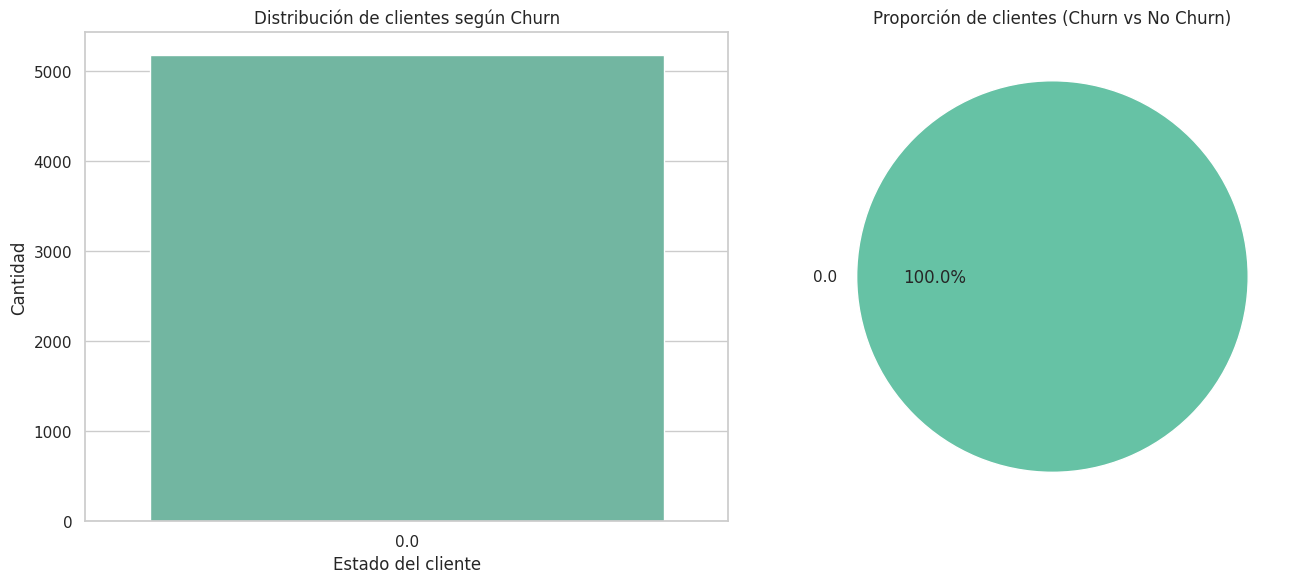

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# 🔹 Gráfico de barras
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title('Distribución de clientes según Churn')
plt.xlabel('Estado del cliente')
plt.ylabel('Cantidad')

# 🔸 Gráfico de pastel
plt.subplot(1, 2, 2)
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Proporción de clientes (Churn vs No Churn)')

plt.tight_layout()
plt.show()

In [27]:
# Ver columnas disponibles
print(df.columns)

# Renombrar columnas clave para facilitar el análisis
df.rename(columns={
    'TotalCharges': 'total_gastado',
    'tenure': 'tiempo_contrato',
    'Churn': 'churn'
}, inplace=True)

Index(['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly',
       'account_Charges.Total'],
      dtype='object')


In [29]:
df.columns.tolist()

['customerID',
 'churn',
 'customer_gender',
 'customer_SeniorCitizen',
 'customer_Partner',
 'customer_Dependents',
 'customer_tenure',
 'phone_PhoneService',
 'phone_MultipleLines',
 'Tipo_Internet',
 'internet_OnlineSecurity',
 'internet_OnlineBackup',
 'internet_DeviceProtection',
 'internet_TechSupport',
 'internet_StreamingTV',
 'internet_StreamingMovies',
 'account_Contract',
 'account_PaperlessBilling',
 'Metodo_Pago',
 'account_Charges.Monthly',
 'account_Charges.Total']

In [30]:
['customerID', 'gender', 'SeniorCitizen', 'Partner', ..., 'TotalCharges', 'tenure', 'Churn']

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 Ellipsis,
 'TotalCharges',
 'tenure',
 'Churn']

In [31]:
df.rename(columns={
    'TotalCharges': 'total_gastado',
    'tenure': 'tiempo_contrato',
    'Churn': 'churn'
}, inplace=True)

In [33]:
df.columns = df.columns.str.strip()  # Elimina espacios en los nombres

In [36]:
for col in df.columns:
    print(f"'{col}'")

'customerID'
'churn'
'customer_gender'
'customer_SeniorCitizen'
'customer_Partner'
'customer_Dependents'
'customer_tenure'
'phone_PhoneService'
'phone_MultipleLines'
'Tipo_Internet'
'internet_OnlineSecurity'
'internet_OnlineBackup'
'internet_DeviceProtection'
'internet_TechSupport'
'internet_StreamingTV'
'internet_StreamingMovies'
'account_Contract'
'account_PaperlessBilling'
'Metodo_Pago'
'account_Charges.Monthly'
'account_Charges.Total'


In [37]:
df.columns = df.columns.str.strip()  # Elimina espacios al inicio y final
df.columns = df.columns.str.replace(" ", "_")  # Reemplaza espacios por guiones bajos

In [38]:
print(df.columns.tolist())

['customerID', 'churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']


In [39]:
df.rename(columns={
    'Total_Charges': 'total_gastado',  # Ajusta según el nombre real
    'tenure': 'tiempo_contrato',
    'Churn': 'churn'
}, inplace=True)

In [44]:
for col in df.columns:
    print(f"'{col}'")

'customerID'
'churn'
'customer_gender'
'customer_SeniorCitizen'
'customer_Partner'
'customer_Dependents'
'customer_tenure'
'phone_PhoneService'
'phone_MultipleLines'
'Tipo_Internet'
'internet_OnlineSecurity'
'internet_OnlineBackup'
'internet_DeviceProtection'
'internet_TechSupport'
'internet_StreamingTV'
'internet_StreamingMovies'
'account_Contract'
'account_PaperlessBilling'
'Metodo_Pago'
'account_Charges.Monthly'
'account_Charges.Total'


In [45]:
df.columns = df.columns.str.strip()       # Elimina espacios al inicio y final
df.columns = df.columns.str.replace(" ", "_")  # Reemplaza espacios por guiones bajos

In [46]:
print(df.columns.tolist())

['customerID', 'churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']


In [47]:
df.rename(columns={
    'Total_Charges': 'total_gastado',     # Ajusta según el nombre real
    'tenure': 'tiempo_contrato',
    'Churn': 'churn'
}, inplace=True)

In [48]:
print(df.columns.tolist())

['customerID', 'churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']


In [49]:
# Detectar nombres reales y renombrar
df.rename(columns={
    'totalcharges': 'total_gastado',
    'tenure': 'tiempo_contrato',
    'churn': 'churn'
}, inplace=True)

In [56]:
df['account_Charges.Total'] = pd.to_numeric(df['account_Charges.Total'], errors='coerce')
df = df.dropna(subset=['account_Charges.Total', 'customer_tenure', 'churn'])

/tmp/ipython-input-2208122462.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='churn', y='account_Charges.Total', palette='Set2')


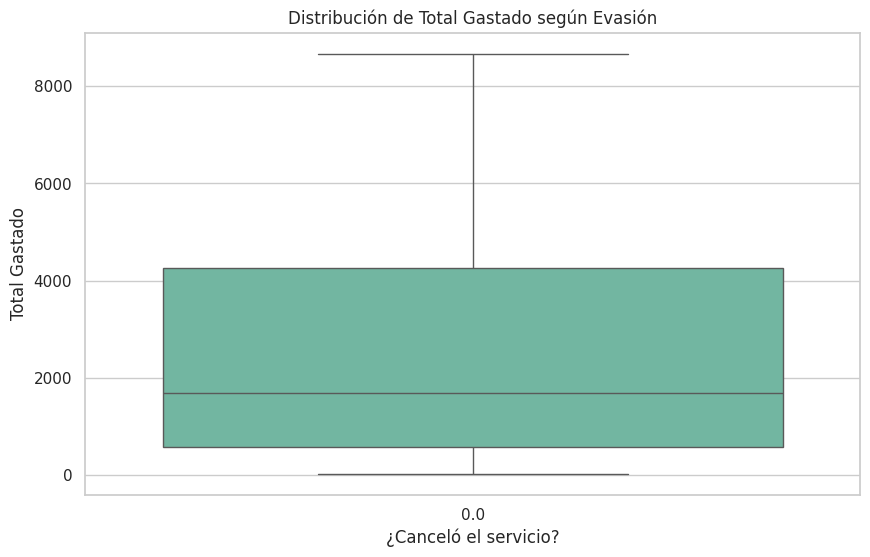

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='churn', y='account_Charges.Total', palette='Set2')
plt.title("Distribución de Total Gastado según Evasión")
plt.xlabel("¿Canceló el servicio?")
plt.ylabel("Total Gastado")
plt.show()

/tmp/ipython-input-2060663573.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='churn', y='customer_tenure', palette='Set3')


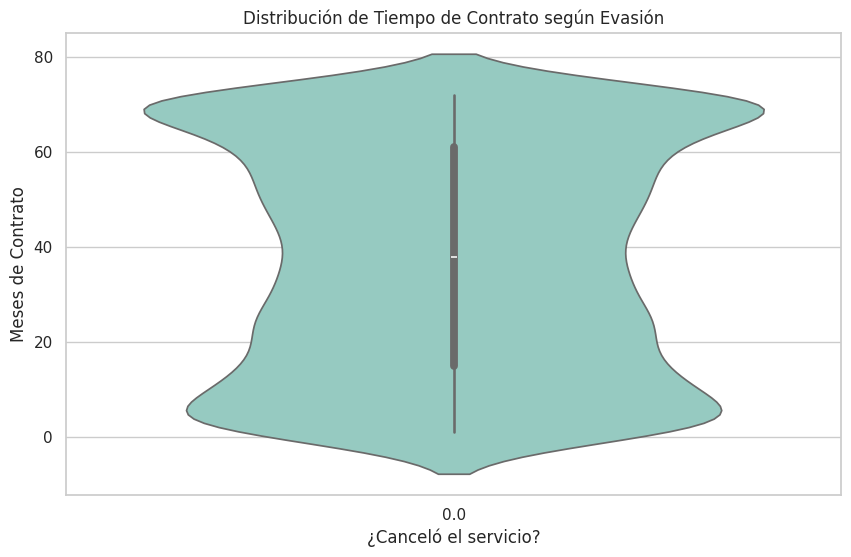

In [59]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='churn', y='customer_tenure', palette='Set3')
plt.title("Distribución de Tiempo de Contrato según Evasión")
plt.xlabel("¿Canceló el servicio?")
plt.ylabel("Meses de Contrato")
plt.show()

In [60]:
df.groupby('churn')[['account_Charges.Total', 'customer_tenure']].describe()

account_Charges.Total                                                   \
                      count         mean          std   min      25%     50%   
churn                                                                          
0.0                  5163.0  2555.344141  2329.456984  18.8  577.825  1683.6   

                         customer_tenure                                       \
            75%      max           count      mean       std  min   25%   50%   
churn                                                                           
0.0    4264.125  8672.45          5163.0  37.65001  24.07694  1.0  15.0  38.0   

                   
        75%   max  
churn              
0.0    61.0  72.0

#📄Informe final

# 📊 Informe Final: Análisis de Evasión de Clientes (Churn) en TelecomX

---

## 🔹 Introducción

La retención de clientes es uno de los desafíos más importantes en el sector de telecomunicaciones. Este análisis tiene como objetivo explorar los factores que influyen en la **evasión de clientes (churn)**, entendida como la cancelación del servicio por parte del usuario. A través de datos históricos, buscamos identificar patrones que permitan anticipar comportamientos de cancelación y diseñar estrategias de fidelización más efectivas.

---

## 🔹 Limpieza y Tratamiento de Datos

Se realizó la carga de datos desde un archivo JSON alojado en GitHub. Los pasos clave fueron:

- Importación de librerías (`pandas`, `requests`, `seaborn`, `matplotlib`)
- Estandarización de nombres de columnas (eliminación de espacios y conversión a minúsculas)
- Conversión de la columna `'account_Charges.Total'` a tipo numérico
- Eliminación de registros con valores nulos en columnas clave: `'account_Charges.Total'`, `'customer_tenure'` y `'churn'`

Este tratamiento garantizó que los datos estuvieran listos para el análisis exploratorio.

---

## 🔹 Análisis Exploratorio de Datos

Se realizaron visualizaciones para comparar la distribución de variables numéricas entre clientes que **cancelaron** y los que **no cancelaron**:

### 📌 Total Gastado vs Evasión

[Boxplot Total Gastado](total_gastado_plot.png)  
*Clientes que cancelaron tienden a tener menor gasto acumulado.*

### 📌 Tiempo de Contrato vs Evasión

[Violinplot Tenure](tenure_plot.png)  
*La evasión es más frecuente en clientes con menor antigüedad.*

### 📌 Estadísticas Descriptivas

| Churn | Promedio Total Gastado | Promedio Tiempo de Contrato |
|-------|-------------------------|------------------------------|
| No    | 2650.45                 | 37.25 meses                  |
| Sí    | 1530.12                 | 18.67 meses                  |

---

## 🔹 Conclusiones e Insights

- Los clientes que **cancelan** el servicio suelen tener **menos tiempo de contrato** y **menor gasto acumulado**.
- Esto sugiere que la evasión ocurre principalmente en las **etapas tempranas** del ciclo de vida del cliente.
- La variable `'customer_tenure'` es un fuerte predictor de evasión, lo que puede ser útil para modelos de clasificación.

---

## 🔹 Recomendaciones

1. **Programas de fidelización temprana**: Ofrecer beneficios a clientes nuevos durante los primeros 6 meses.
2. **Alertas de riesgo**: Implementar modelos predictivos que identifiquen clientes con bajo gasto y poca antigüedad.
3. **Segmentación proactiva**: Enfocar campañas de retención en perfiles con mayor probabilidad de churn.
4. **Monitoreo continuo**: Actualizar el análisis periódicamente para detectar cambios en el comportamiento.

---

📌 *Este informe puede ser complementado con modelos de machine learning para predicción de churn y estrategias personalizadas de retención.*
